<a href="https://colab.research.google.com/github/omkar-shetty/SVHN_image_recognition/blob/main/DNN_SVHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classifier for the SVHN dataset

This script uses DNNs to identify numbers from real world photos. 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

from scipy.io import loadmat
from random import sample

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras import initializers, optimizers, regularizers, callbacks
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## 1. Access Data 

In [2]:
# mount g-drive
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Verify that the (cropped) datasets are available in the right folder
!ls "/content/drive/My Drive/Data/SVHN"

test_32x32.mat	train_32x32.mat


In [4]:
# Load the dataset

train = loadmat('/content/drive/My Drive/Data/SVHN/train_32x32.mat')
test = loadmat('/content/drive/My Drive/Data/SVHN/test_32x32.mat')

## 2. Explore the dataset

Here we define a set of functions to inspect the shape of the dataset as well as look at some examples of the images available.  
Finally, we convert them to grayscale and re-look at the same examples.

In [5]:
# Exract features and labels

def extract_features(train, test):
    # Extracting training images and labels
    x_train = train['X']
    y_train = train['y']

    # Extracting Test images nd labels
    x_test = test['X']
    y_test = test['y']
    
    return(x_train, y_train, x_test, y_test)

In [6]:
x_train, y_train, x_test, y_test = extract_features(train, test)

x_train.shape

(32, 32, 3, 73257)

In [7]:
# Reshape the data 
x_train = np.moveaxis(x_train, 3, -4)
x_test = np.moveaxis(x_test, 3, -4)
x_train.shape

(73257, 32, 32, 3)

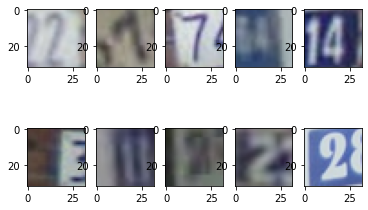

[2]
[7]
[7]
[4]
[4]
[3]
[1]
[2]
[2]
[2]


In [8]:
# Select random images and print the image and the label

random.seed(10)
samples = sample(range(1,x_train.shape[0]),10)

columns = 5
rows = 2
fig = plt.figure()
for i in range(1,len(samples)+1) :
    img = x_train[samples[i-1],:,:,:]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

for i in range(1, len(samples)+1):
    print(y_train[samples[i-1]])

In [9]:
# Converting images to grayscale

def convert_to_gray(dt):
    dt_gray = np.mean(dt, axis=3)
    dt_gray = dt_gray/255
    return dt_gray

In [10]:
x_train_gray = convert_to_gray(x_train)
x_test_gray = convert_to_gray(x_test)

In [11]:
x_train_gray.shape

(73257, 32, 32)

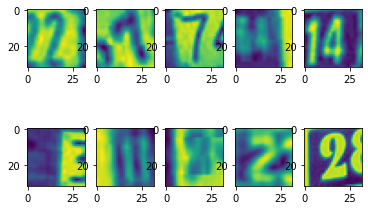

In [12]:
# Reprint the same samples, now in grayscale

columns = 5
rows = 2
fig = plt.figure()
for i in range(1,len(samples)+1) :
    img = x_train_gray[samples[i-1],:,:]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [13]:
# adding channel dimension

x_train_gray = x_train_gray[...,np.newaxis]
x_test_gray = x_test_gray[...,np.newaxis]

## Basic Neural Net Classifier

Starting with a non CNN classifier. The categorical cross-entropy will be used as the loss function. 

In [22]:
def get_mlp_model(input_shape):
    
    model = Sequential([
        Dense(64, input_shape = input_shape, activation = 'relu', name = 'input'),
        Flatten(),
        Dense(128, activation = 'relu', name = 'dense_1'),
        Dense(128, activation = 'relu', name = 'dense_2'),
        Dense(128, activation = 'relu', name = 'dense_3'),
        Dense(128, activation = 'relu', name = 'dense_4'),
        Dense(10, activation = 'softmax', name = 'output')
    ])
    return model

In [23]:
def compile_model(model):
    """
    This function takes in the model returned from your get_model function, and compiles it with an optimiser,
    loss function and metric.
    Compile the model using the Adam optimiser (with learning rate set to 0.0001), 
    the categorical crossentropy loss function and accuracy as the only metric. 
    Your function doesn't need to return anything; the model will be compiled in-place.
    """
    model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics= ['accuracy'])

In [24]:
def train_model(model, train_data, train_targets, epochs, verbose, callbacks):
    """
    This function should train the model for the given number of epochs on the 
    train_data and train_targets. 
    Your function should return the training history, as returned by model.fit.
    """
    history = model.fit(x = train_data, 
                        y = train_targets,
                        epochs = epochs,
                        validation_split = 0.15,
                        batch_size = 40,
                        verbose = verbose,
                       callbacks = callbacks)
    return history

In [25]:
# Changing the label

y_train = np.where(y_train==10, 0, y_train)

In [26]:
def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 3 epochs.
 
    """
    return tf.keras.callbacks.EarlyStopping(patience = 3, monitor= 'loss', mode = 'min')

In [27]:
def get_checkpoint_best_only():
    """
    This function should return a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing) accuracy
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint' 
    """
    checkpoint_best_path = 'checkpoints_best_only/checkpoint'
    checkpoint = ModelCheckpoint(filepath=checkpoint_best_path, 
                             frequency = 'epoch',
                             save_weights_only=True,
                             monitor = 'loss',
                             save_best_only = True,
                             verbose = 1)
    return checkpoint

In [28]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
callbacks = [checkpoint_best_only, early_stopping]

In [29]:
base_model = get_mlp_model(x_train_gray[0].shape)
compile_model(base_model)
history = train_model(base_model, x_train_gray, y_train, epochs=20, verbose = True, callbacks = callbacks)

Epoch 1/20
1557/1557 [==============================] - ETA: 0s - loss: 1.6105 - accuracy: 0.4489
Epoch 00001: loss improved from inf to 1.61046, saving model to checkpoints_best_only/checkpoint
1557/1557 [==============================] - 156s 100ms/step - loss: 1.6105 - accuracy: 0.4489 - val_loss: 1.2338 - val_accuracy: 0.5995
Epoch 2/20
1557/1557 [==============================] - ETA: 0s - loss: 1.0902 - accuracy: 0.6520
Epoch 00002: loss improved from 1.61046 to 1.09025, saving model to checkpoints_best_only/checkpoint
1557/1557 [==============================] - 165s 106ms/step - loss: 1.0902 - accuracy: 0.6520 - val_loss: 1.0309 - val_accuracy: 0.6674
Epoch 3/20
1557/1557 [==============================] - ETA: 0s - loss: 0.9811 - accuracy: 0.6899
Epoch 00003: loss improved from 1.09025 to 0.98109, saving model to checkpoints_best_only/checkpoint
1557/1557 [==============================] - 165s 106ms/step - loss: 0.9811 - accuracy: 0.6899 - val_loss: 1.0130 - val_accuracy: 0.6